In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression


In [2]:
train = pd.read_csv('cleaned_hm.csv')

In [3]:
train[:20]

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection
5,27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
6,27679,195,24h,"I made a new recipe for peasant bread, and it ...","I made a new recipe for peasant bread, and it ...",True,1,NaN,achievement
7,27680,740,24h,I got gift from my elder brother which was rea...,I got gift from my elder brother which was rea...,True,1,NaN,affection
8,27681,3,24h,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,True,1,NaN,enjoy_the_moment
9,27682,4833,24h,Watching cupcake wars with my three teen children,Watching cupcake wars with my three teen children,True,1,NaN,affection


In [4]:
demo = pd.read_csv('demographic.csv')
demo[:20]

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y
5,6,35,IND,m,married,y
6,7,34,USA,m,married,y
7,8,29,VNM,m,single,n
8,9,61,USA,f,married,y
9,10,27,USA,m,single,n


In [5]:
df_train = train[train['cleaned_hm'].notnull()]
len_count = df_train['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100535.000000
mean         18.298503
std          21.474146
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

(-0.5, 3599.5, 2699.5, -0.5)

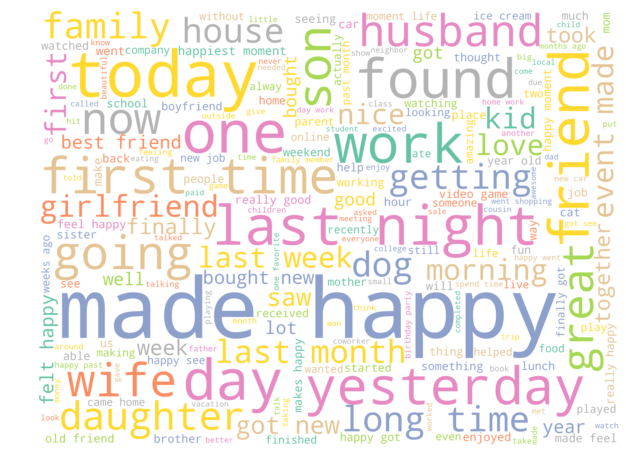

In [6]:
text = ' '.join(df_train['cleaned_hm'].tolist())
text = text.lower()
wordcloud = WordCloud(background_color="white", height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

(-0.5, 3599.5, 2699.5, -0.5)

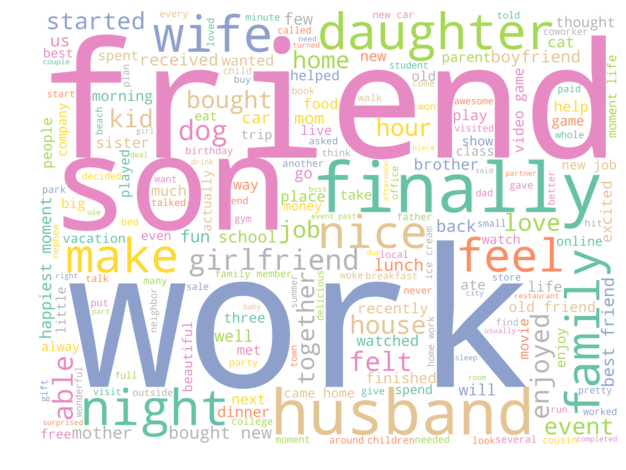

In [7]:
LIMIT_WORDS = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', 'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without', 'yesteri', '2s', 'toand', 'ing']

text = ' '.join(df_train['cleaned_hm'].tolist())
text = text.lower()
for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')
wordcloud = WordCloud(background_color="white", height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

In [8]:
merge_data = pd.merge(train, demo, on='wid')
marital_data = merge_data[['cleaned_hm', 'marital']]
marital_data[marital_data['marital'] == "single"][:20]

,cleaned_hm,marital
0,I went on a successful date with someone I fel...,single
1,I played a new game that was fun and got to en...,single
2,I listened to some music and heard an entire a...,single
3,Went to see a movie with my friend,single
4,"Played guitar, learning a song on it",single
5,Talked to my romantic prospect,single
6,I played a game for about half an hour.,single
7,I discovered another album I hadn't heard by a...,single
8,I talked to the girl I'm dating about some int...,single
159,I meditated last night.,single


In [9]:
marital_data[marital_data['marital'] == "married"][:10]

,cleaned_hm,marital
9,I was happy when my son got 90% marks in his e...,married
10,I was very happy when my family brings me beau...,married
11,I was happy when I got my new incentives from ...,married
12,When my family cooked my favorite food at night,married
13,When my son got recovery from their disease,married
14,When my mother got finalized stay for transfer...,married
15,When my family plan a abroad tour with me,married
16,When my son realize their emotions and duty,married
17,When my brother got a new job offer from abroad,married
18,I was very happy last 24 hours when I received...,married


In [10]:
marital_data[marital_data['marital'] == "divorced"][:10]

,cleaned_hm,marital
156,I went with grandchildren to butterfly display...,divorced
157,had a great lunch with daughter and grandchil...,divorced
158,I made vacation plans with my daughter today f...,divorced
1152,I picked my daughter up from the airport and w...,divorced
1153,The rain stopped and beautiful sunlight appear...,divorced
1154,My cat has been sick and yesterday she ate som...,divorced
1629,I cooked and ate a wonderful sausage and chees...,divorced
1630,I spoke with my ex-wife on the phone and made ...,divorced
1631,I received a message from a seemingly charming...,divorced
1632,"I met someone last week, who's smart, funny, b...",divorced


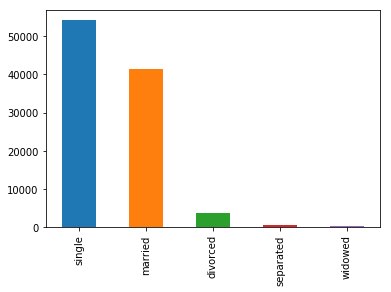

In [11]:
marital_data.marital.value_counts().plot(kind='bar')

In [12]:
marital_bin_data = marital_data[(marital_data['marital'] == 'single') | (marital_data['marital'] == 'married')]
print("Happy moments written by single or married: {}".format(marital_bin_data['cleaned_hm'].size))

Happy moments written by single or married: 95449


In [13]:
marital_bin_data = marital_bin_data.assign(marital_bin=(np.where(marital_bin_data['marital']=='single', 1, 0)))
marital_bin_data.head()

,cleaned_hm,marital,marital_bin
0,I went on a successful date with someone I fel...,single,1
1,I played a new game that was fun and got to en...,single,1
2,I listened to some music and heard an entire a...,single,1
3,Went to see a movie with my friend,single,1
4,"Played guitar, learning a song on it",single,1


In [14]:
hm_size = marital_bin_data['cleaned_hm'].size
num_train_hm = int(0.7 * marital_bin_data['cleaned_hm'].size)
train_hm = marital_bin_data.iloc[0:num_train_hm]
test_hm = marital_bin_data.iloc[num_train_hm:hm_size]
test_hm = test_hm.reset_index(drop=True)

test_hm.head()


,cleaned_hm,marital,marital_bin
0,I found one of my favorite TV shows on and it ...,single,1
1,I ordered a Cinnamon Dulce Cappuccino at Starb...,single,1
2,"My dog Maggie wagged her tail, wiggled, and ba...",single,1
3,I washed my pajamas and when I took them out o...,single,1
4,My 9 month old son was laughing so hard at our...,married,0


In [15]:
def clean_up_texts(hm_data):
    prepro_hm = []
    stops = set(stopwords.words("english"))
    for i in range(0, hm_data['cleaned_hm'].size):
        # Remove non-english words, including punctuations and numbers
        letters = re.sub("[^a-zA-Z]", " ", hm_data.iloc[i]['cleaned_hm'])

        # Convert all words to lower case
        lower_words = letters.lower()

        # Tokenize the sentences
        tokens = lower_words.split()

        # Reconstruct the processed tokens into a string
        prepro_string = " ".join(tokens)

        prepro_hm.append(prepro_string)
        
    return prepro_hm
    
prepro_train = clean_up_texts(train_hm)
prepro_test = clean_up_texts(test_hm)
print("Texts cleaned up! \n")

Texts cleaned up! 



In [16]:
prepro_train[:10]

['i went on a successful date with someone i felt sympathy and connection with',
 'i played a new game that was fun and got to enjoy the mechanics of it',
 'i listened to some music and heard an entire album i hadn t heard more than once before',
 'went to see a movie with my friend',
 'played guitar learning a song on it',
 'talked to my romantic prospect',
 'i played a game for about half an hour',
 'i discovered another album i hadn t heard by a band i recently got into',
 'i talked to the girl i m dating about some interesting topics',
 'i was happy when my son got marks in his examination']

In [17]:
vectorizer = CountVectorizer(analyzer = "word")
features_train_hm = vectorizer.fit_transform(prepro_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_train_hm)
features_train_hm_tf = tf_transformer.transform(features_train_hm)
train_array_hm = features_train_hm_tf.toarray()
print("Dimension of the training data: {}".format(train_array_hm.shape))

Dimension of the training data: (66814, 20376)


In [18]:
vocab = vectorizer.get_feature_names()
vocab[:20]

['aa',
 'aaa',
 'aadat',
 'aadhaar',
 'aadhar',
 'aagra',
 'aakshayatriya',
 'aas',
 'aashwin',
 'ab',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abasket',
 'abating',
 'abbott',
 'abby',
 'abc',
 'abcs']

In [19]:
# LogisticRegression
logi_model = LogisticRegression()
logi_model.fit(train_array_hm, train_hm['marital_bin'])

logi_model.score(train_array_hm, train_hm['marital_bin'])

0.7259257041937318

In [20]:
feature_names = vocab
coefficients = logi_model.coef_.tolist()[0]
weight_df = pd.DataFrame({'Word': feature_names,
                          'Coeff': coefficients})
weight_df = weight_df.sort_values(['Coeff', 'Word'], ascending=[0, 1])
weight_df.head(n=10)


,Word,Coeff
2147,boyfriend,6.841174
7517,girlfriend,5.587309
6613,fiancee,3.841091
6612,fiance,3.136992
15278,roommate,2.863808
18953,uncle,2.683983
4371,crush,1.981860
19068,university,1.960717
7707,graduate,1.843172
11645,mth,1.815267


In [21]:
weight_df.tail(n=10)

,Word,Coeff
16965,spouse,-4.056279
9793,kid,-4.078292
4582,daughters,-4.157258
3129,child,-4.377459
3136,children,-4.442055
9800,kids,-5.961525
16719,son,-6.952189
4581,daughter,-7.773861
19937,wife,-9.399643
8698,husband,-11.522440


In [22]:
features_test_hm = vectorizer.transform(prepro_test)
tf_transformer = TfidfTransformer(use_idf=False).fit(features_test_hm)
features_test_hm_tf = tf_transformer.transform(features_test_hm)
test_array_hm = features_test_hm_tf.toarray()
print("Dimension of the test data: {}".format(test_array_hm.shape))

Dimension of the test data: (28635, 20376)


In [23]:
accuracy_result = []
f1_result = []
algorithm = []

In [24]:
predictions = logi_model.predict(test_array_hm)

In [25]:
from sklearn import metrics
print(metrics.accuracy_score(test_hm['marital_bin'], predictions))
print(metrics.f1_score(test_hm['marital_bin'], predictions))
accuracy_result.append(metrics.accuracy_score(test_hm['marital_bin'], predictions))
f1_result.append(metrics.f1_score(test_hm['marital_bin'], predictions))
algorithm.append("Logistic Regression")

0.6977475117862756
0.7655043485328781


In [26]:
def predict_evaluate (clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result):
    clf = clf.fit(train_array_hm, train_hm['marital_bin'])
    predictions = clf.predict(test_array_hm)
    print(metrics.accuracy_score(test_hm['marital_bin'], predictions))
    print(metrics.f1_score(test_hm['marital_bin'], predictions))
    accuracy_result.append(metrics.accuracy_score(test_hm['marital_bin'], predictions))
    f1_result.append(metrics.f1_score(test_hm['marital_bin'], predictions))

In [27]:
# LinearSVC
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)
algorithm.append("LinearSVC")

0.6877248122926488
0.7510440447686397


In [28]:
# MultinomialNB
clf = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)
algorithm.append("MultinomialNB")

0.678016413480007
0.7474526131258902


In [29]:
# BernoulliNB
clf = BernoulliNB(alpha=0.01, class_prior=None, fit_prior=True)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)
algorithm.append("BernoulliNB")

0.6496245852977126
0.7114715440140339


In [30]:
# GaussianNB
clf = GaussianNB()
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)
algorithm.append("GaussianNB")

0.47592107560677493
0.3444148355248788


In [31]:
#Decision Tree
clf = DecisionTreeClassifier(max_depth=5)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)
algorithm.append("Decision Tree")

0.6864326872708224
0.7843193773870434


In [36]:
#Plot stuff
ac_store = accuracy_result
f1_store = f1_result
al_store = algorithm

[0.6977475117862756,
 0.6877248122926488,
 0.678016413480007,
 0.6496245852977126,
 0.47592107560677493,
 0.6864326872708224]

In [50]:
f1_store[0:len(al_store)]

[0.7655043485328781,
 0.7510440447686397,
 0.7474526131258902,
 0.7114715440140339,
 0.3444148355248788,
 0.7843193773870434]

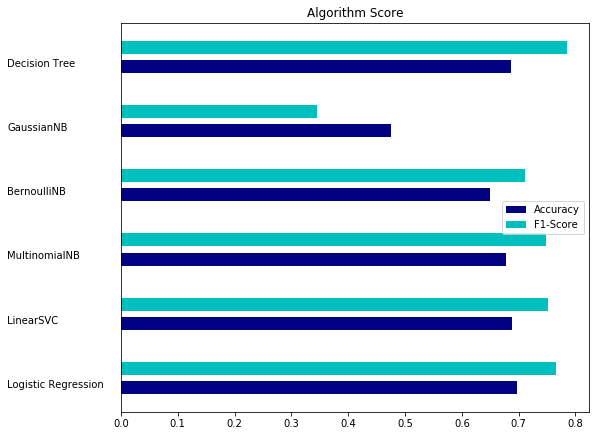

In [69]:
indices = np.arange(len(al_store))

plt.figure(figsize=(10, 6))
plt.title("Algorithm Score")
plt.barh(indices, ac_store[0:len(al_store)], .2, label="Accuracy", color='navy')
plt.barh(indices + .3, f1_store[0:len(al_store)], .2, label="F1-Score",
         color='c')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, al_store):
    plt.text(-.2, i, c)

plt.show()

In [37]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=7)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

0.6749083289680461
0.766170153977544


In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

0.6621267679413305
0.773774171674422


In [39]:
clf = DecisionTreeClassifier(max_depth=9)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

0.6898550724637681
0.7825363010847475


In [40]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="hinge", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="hinge", penalty="elasticnet", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="perceptron", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

0.6990047145102147
0.7737260770260692
0.6991094814038764
0.7784064605730159
0.6983062685524708
0.7804406943350192
0.698341190850358
0.7835630167877725
0.6445259298061813
0.7073402144849199


In [41]:
clf = SGDClassifier(loss="log", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="modified_huber", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="squared_hinge", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

clf = SGDClassifier(loss="hinge", penalty="elasticnet", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

0.701134974681334
0.7818728653718713
0.7023223328094989
0.7776038405343353
0.601920726383796
0.6278363642299781
0.6985507246376812
0.7834311806914546


In [67]:
clf = SGDClassifier(loss="perceptron", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, accuracy_result, f1_result)

0.6318142133752401
0.759977233921457


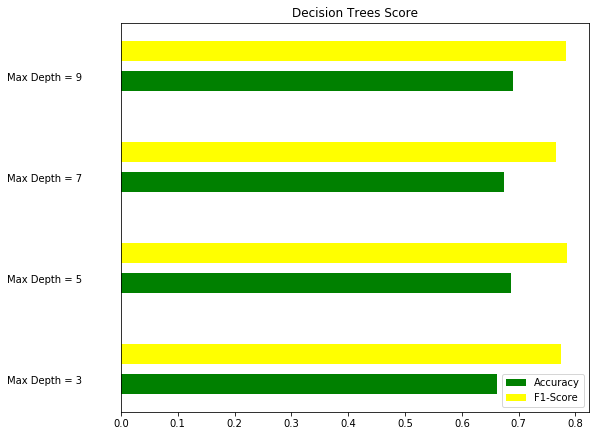

In [70]:
# Plot Decision Trees Comparison
# Do Label
Tree_label= []
Tree_label.append("Max Depth = 3")
Tree_label.append("Max Depth = 5")
Tree_label.append("Max Depth = 7")
Tree_label.append("Max Depth = 9")
# Get Accuracy
Tree_ac = []
Tree_ac.append(accuracy_result[7])
Tree_ac.append(accuracy_result[5])
Tree_ac.append(accuracy_result[6])
Tree_ac.append(accuracy_result[8])
# Get F-1 Score
Tree_f1 = []
Tree_f1.append(f1_result[7]) 
Tree_f1.append(f1_result[5]) 
Tree_f1.append(f1_result[6]) 
Tree_f1.append(f1_result[8]) 
#Plot Decision Trees Algorithm
indices = np.arange(len(Tree_label))
plt.figure(figsize=(10, 6))
plt.title("Decision Trees Score")
plt.barh(indices, Tree_ac, .2, label="Accuracy", color='green')
plt.barh(indices + .3, Tree_f1, .2, label="F1-Score",
         color='yellow')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
for i, c in zip(indices, Tree_label):
    plt.text(-.2, i, c)
plt.show()


0.6862929980792736
0.7488045636307711
0.699039636808102
0.7758764173515031
0.6993190151911995
0.7780699041138261
0.6995983935742972
0.7781960703419113


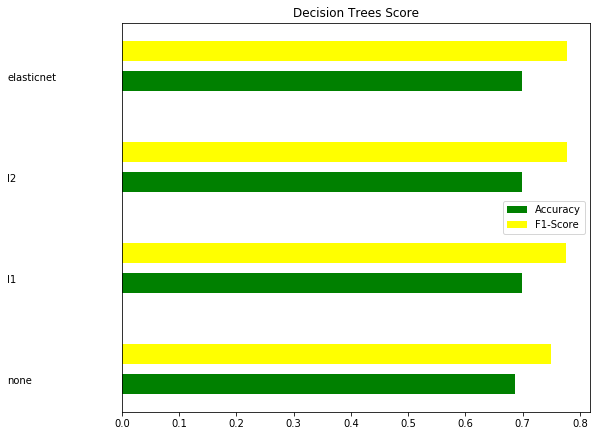

In [71]:
#SGD classifier with logistic regression with different penalty 
sgd_accuracy = []
sgd_f1score = []
sgd_label = []

clf = SGDClassifier(loss="log", penalty="none", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd_accuracy, sgd_f1score)
sgd_label.append("none")
clf = SGDClassifier(loss="log", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd_accuracy, sgd_f1score)
sgd_label.append("l1")
clf = SGDClassifier(loss="log", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd_accuracy, sgd_f1score)
sgd_label.append("l2")
clf = SGDClassifier(loss="log", penalty="elasticnet", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd_accuracy, sgd_f1score)
sgd_label.append("elasticnet")



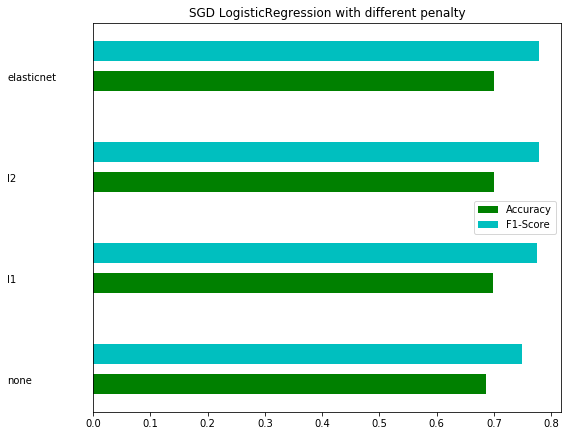

In [76]:
#Plot SGD classifier with different penalties
indices = np.arange(len(sgd_label))
plt.figure(figsize=(10, 6))
plt.title("SGD LogisticRegression with different penalty")
plt.barh(indices, sgd_accuracy, .2, label="Accuracy", color='green')
plt.barh(indices + .3, sgd_f1score, .2, label="F1-Score",
         color='c')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
for i, c in zip(indices, sgd_label):
    plt.text(-.15, i, c)
plt.show()

In [75]:
sgd2_accuracy = []
sgd2_f1score = []
sgd2_label = []

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd2_accuracy, sgd2_f1score)
sgd2_label.append("hinge (Linear SVM)")
clf = SGDClassifier(loss="log", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd2_accuracy, sgd2_f1score)
sgd2_label.append("log (Logistic Regression)")
clf = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd2_accuracy, sgd2_f1score)
sgd2_label.append("modified_huber")
clf = SGDClassifier(loss="squared_hinge", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd2_accuracy, sgd2_f1score)
sgd2_label.append("squared_hinge")
clf = SGDClassifier(loss="perceptron", penalty="l2", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd2_accuracy, sgd2_f1score)
sgd2_label.append("perceptron")

0.6990745591059891
0.7802178182467417
0.695756940806705
0.7689859991514637
0.6860834642919504
0.7438082480690854
0.6113846691112275
0.6591939238025236
0.5213200628601362
0.40884978651830767


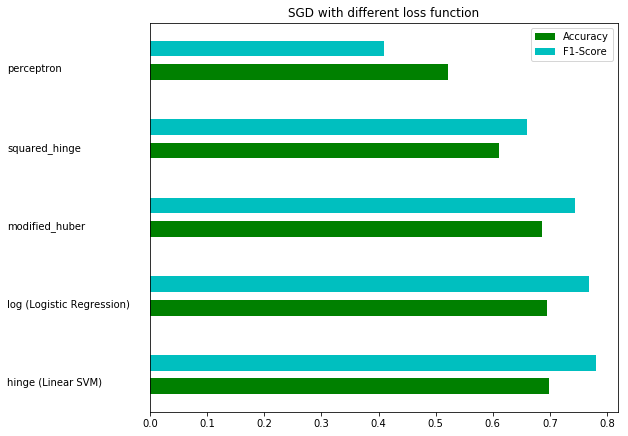

In [81]:
#Plot SGD classifier with different loss function
indices = np.arange(len(sgd2_label))
plt.figure(figsize=(10, 6))
plt.title("SGD with different loss function")
plt.barh(indices, sgd2_accuracy, .2, label="Accuracy", color='green')
plt.barh(indices + .3, sgd2_f1score, .2, label="F1-Score",
         color='c')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
for i, c in zip(indices, sgd2_label):
    plt.text(-.25, i, c)
plt.show()

In [83]:
sgd3_accuracy = []
sgd3_f1score = []
sgd3_label = []

clf = SGDClassifier(loss="log", penalty="l1", max_iter=2)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd3_accuracy, sgd3_f1score)
sgd3_label.append("n = 2")
clf = SGDClassifier(loss="log", penalty="l1", max_iter=4)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd3_accuracy, sgd3_f1score)
sgd3_label.append("n = 4")
clf = SGDClassifier(loss="log", penalty="l1", max_iter=6)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd3_accuracy, sgd3_f1score)
sgd3_label.append("n = 6")
clf = SGDClassifier(loss="log", penalty="l1", max_iter=8)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd3_accuracy, sgd3_f1score)
sgd3_label.append("n = 8")
clf = SGDClassifier(loss="log", penalty="l1", max_iter=10)
predict_evaluate(clf, train_array_hm, train_hm, test_array_hm, test_hm, sgd3_accuracy, sgd3_f1score)
sgd3_label.append("n = 10")

0.7001920726383796
0.7784230223254613
0.6954426401257203
0.7712644582579276
0.6958617077003667
0.7715072805981897
0.6982364239566964
0.7733745967636182
0.6971538327221931
0.7721971209414731


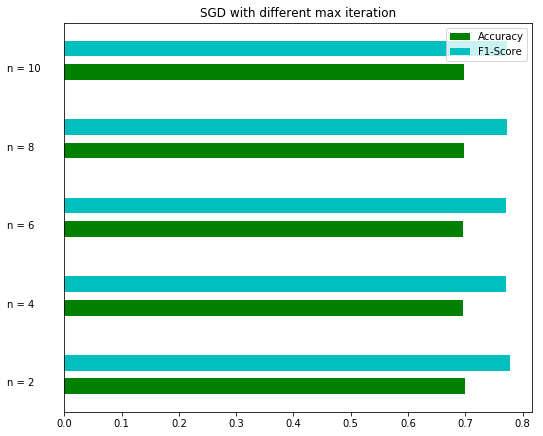

In [89]:
#Plot SGD classifier with different max iteration
indices = np.arange(len(sgd3_label))
plt.figure(figsize=(10, 6))
plt.title("SGD with different max iteration")
plt.barh(indices, sgd3_accuracy, .2, label="Accuracy", color='green')
plt.barh(indices + .3, sgd3_f1score, .2, label="F1-Score",
         color='c')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
for i, c in zip(indices, sgd3_label):
    plt.text(-.1, i, c)
plt.show()